**Import Libraries**

In [14]:
pip install lightly mambavision transformers mamba_ssm timm

  Using cached mambavision-1.0.9-py3-none-any.whl.metadata (13 kB)
  Using cached timm-0.9.0-py3-none-any.whl.metadata (68 kB)
  Using cached mamba_ssm-1.0.1.tar.gz (28 kB)
  Preparing metadata (setup.py) ... done
  Using cached causal_conv1d-1.0.2.tar.gz (6.4 kB)
  Preparing metadata (setup.py) ... done
  Using cached buildtools-1.0.6-py3-none-any.whl
  Using cached SQLAlchemy-2.0.38-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached twisted-24.11.0-py3-none-any.whl.metadata (20 kB)
  Using cached simplejson-3.20.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
  Using cached furl-2.1.3-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Using cached redo-3.0.0-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached orderedmultidict-1.0.1-py2.py3-none-any.whl.metadata (1.3 

In [15]:
# Standard Libraries
import os
import copy
import random
from glob import glob

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

**Define Parameters**

In [16]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42

# Parameteres SimCLR
LEARNING_RATE_SIMCLR = 1e-4
SIMCLR_EPOCHS = 10
BATCH_SIZE_SIMCLR = 32
TEMPERATURE_SIMCLR = 0.5

# Parameteres fine tuning
LEARNING_RATE = 1e-4
TEST_SIZE = 0.2
EPOCHS = 3
BATCH_SIZE = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [17]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [18]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [19]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [20]:
# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


# **Step 3: Pre-train using BYOL**

**Define the BYOL transformations**

In [21]:
byol_transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=224, gaussian_blur=0.0),
    view_2_transform=BYOLView2Transform(input_size=224, gaussian_blur=0.0),
)

**Define the BYOL model**

In [22]:
class BYOL(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T2-1K"):
        super().__init__()

        # The online network
        self.backbone = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        self.projection_head = BYOLProjectionHead(640, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        # The target network
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        # Freeze the teacher network. Only update using EMA
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward_student(self, x):
        # Forward pass student network
        avg_pool, _ = self.backbone(x)
        z = self.projection_head(avg_pool)
        p = self.prediction_head(z)
        return p

    def forward_teacher(self, x):
        # Forward pass teacher network
        avg_pool, _ = self.backbone_momentum(x)
        z = self.projection_head_momentum(avg_pool)
        return z.detach()

# Initalize BYOL model
model = BYOL().to(device)

**Create BYOL Dataset**

In [23]:
class BYOLDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for BYOL.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']

        # Load image using PIL and convert to RGB
        image = Image.open(img_path).convert("RGB")

        # Apply the BYOL transform to generate two augmented views
        view1, view2 = self.transform(image)

        return view1, view2

# Recreate SimCLR Dataset with the updated __getitem__ method
byol_dataset = BYOLDataset(train_val_df, transform=byol_transform)

**Initialize BYOL DataLoader**

In [24]:
byol_loader = DataLoader(
    byol_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    drop_last=True
)

**Initialize Optimizer and Loss for BYOL**

In [25]:
criterion = NegativeCosineSimilarity()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

**Train BYOL Model**

In [26]:
from lightly.utils.scheduler import cosine_schedule
from PIL import Image


"""
Trains the BYOL model.
"""
for epoch in range(3):
    total_loss = 0.0
    progress_bar = tqdm(byol_loader, desc=f"BYOL Epoch {epoch+1}/{3}")
    momentum_val = cosine_schedule(epoch, 3, 0.996, 1)
    for batch in progress_bar:
        x0, x1 = batch
        update_momentum(model.backbone, model.backbone_momentum, m=momentum_val)
        update_momentum(model.projection_head, model.projection_head_momentum, m=momentum_val)

        x0 = x0.to(device)
        x1 = x1.to(device)

        # Forward pass
        p0 = model.forward_student(x0)
        z0 = model.forward_teacher(x0)
        p1 = model.forward_student(x1)
        z1 = model.forward_teacher(x1)

        # Compute loss
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    avg_loss = total_loss / len(byol_loader)
    print(f"Epoch [{epoch+1}/{3}] - Average Loss: {avg_loss:.4f}")

BYOL Epoch 1/3:   0%|          | 0/2807 [00:00<?, ?it/s]

BYOL Epoch 1/3: 100%|██████████| 2807/2807 [11:52<00:00,  3.94it/s, Loss=-0.593]


Epoch [1/3] - Average Loss: -0.5829


BYOL Epoch 2/3: 100%|██████████| 2807/2807 [11:49<00:00,  3.96it/s, Loss=-0.784]


Epoch [2/3] - Average Loss: -0.6815


BYOL Epoch 3/3: 100%|██████████| 2807/2807 [11:43<00:00,  3.99it/s, Loss=-0.74] 

Epoch [3/3] - Average Loss: -0.7666


**Save pre-trained model**

In [28]:
torch.save(model.state_dict(), '../../models/MambaVision_BYOL.pth')
print("BYOL encoder saved.")

BYOL encoder saved.


**Define Dataset for Chest X-ray images**

In [29]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [30]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image within a range of ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [31]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [32]:
train_size = int((1-TEST_SIZE) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [33]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# **Step 7: Build the Model**

In [34]:
pip install mamba_ssm timm

Note: you may need to restart the kernel to use updated packages.


**Load Model**

In [35]:
model = BYOL()
model.load_state_dict(torch.load('../../models/MambaVision_BYOL.pth'))

/tmp/ipykernel_2654230/175709409.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../models/MambaVision_BYOL.pth'))


<All keys matched successfully>

**Initialize the Multi-Label Classifier Model**

In [39]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, model, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Vision Mamba model
        self.base_model = model.backbone

        print(self.base_model)

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier(model)

MambaVisionModel(
  (model): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm

**Move Model to GPU if Available**

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Using device: cuda


**Define Loss Function and Optimizer**

In [41]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# **Step 8: Train the Model**

In [42]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())

            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch 1/3: 100%|██████████| 562/562 [02:16<00:00,  4.12it/s, Loss=0.162] 


Epoch 1/3 | Training Loss: 0.2299 | Validation Loss: 0.1590 | Mean Validation AUC: 0.7858


Epoch 2/3: 100%|██████████| 562/562 [01:54<00:00,  4.89it/s, Loss=0.164] 


Epoch 2/3 | Training Loss: 0.1518 | Validation Loss: 0.1529 | Mean Validation AUC: 0.8118


Epoch 3/3: 100%|██████████| 562/562 [02:00<00:00,  4.68it/s, Loss=0.161] 

Epoch 3/3 | Training Loss: 0.1473 | Validation Loss: 0.1501 | Mean Validation AUC: 0.8286


# **Step 9: Evaluate the Model**

In [43]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Apply sigmoid
            preds = torch.sigmoid(outputs).cpu()

            # Store predictions and true labels
            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [02:21<00:00,  4.94it/s]


**Compute Metrics for Each Label**

In [44]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate and add overall metrics
overall_roc_auc = metrics_df['ROC AUC'].mean()
metrics_df.loc['Overall'] = metrics_df.mean()

# Display metrics
print(metrics_df)

                    Accuracy   ROC AUC
Atelectasis         0.902978  0.803526
Consolidation       0.957343  0.808048
Infiltration        0.812909  0.703654
Pneumothorax        0.952543  0.868595
Edema               0.979636  0.890539
Emphysema           0.976406  0.901489
Fibrosis            0.983673  0.797338
Effusion            0.894680  0.873891
Pneumonia           0.986813  0.740854
Pleural_Thickening  0.970396  0.790277
Cardiomegaly        0.971338  0.902990
Nodule              0.942585  0.738840
Mass                0.951377  0.831006
Hernia              0.997847  0.900693
Overall             0.948609  0.825124


**Plot ROC curves for each label**

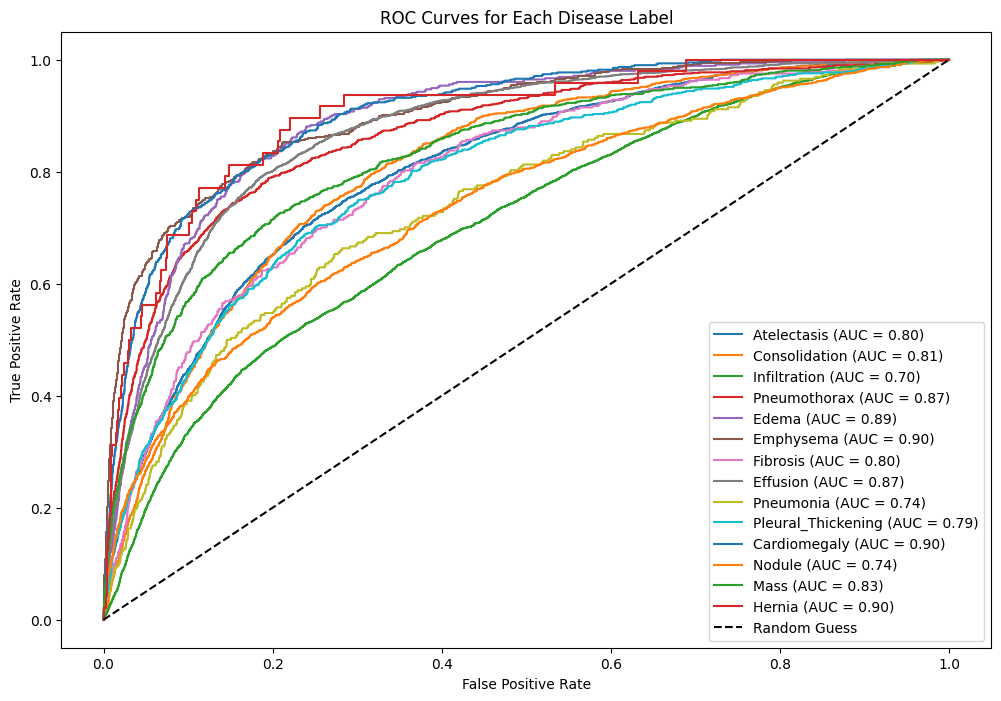

In [45]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

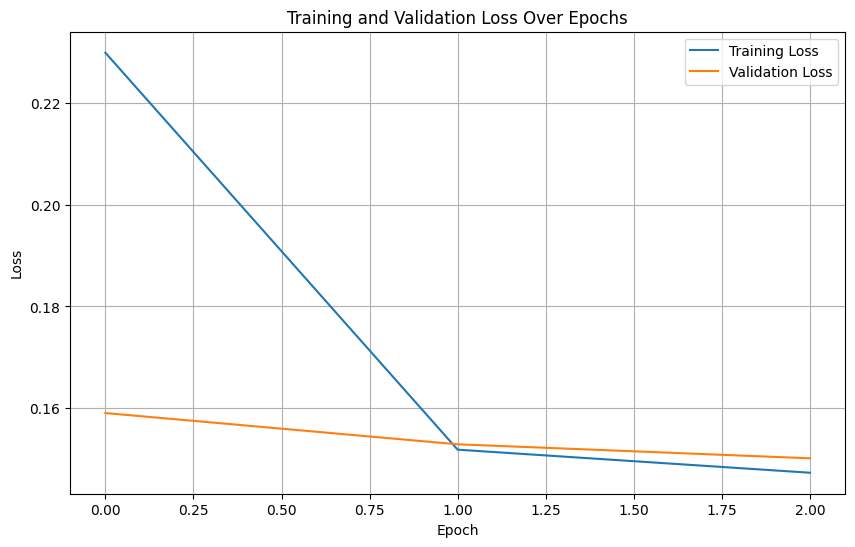

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

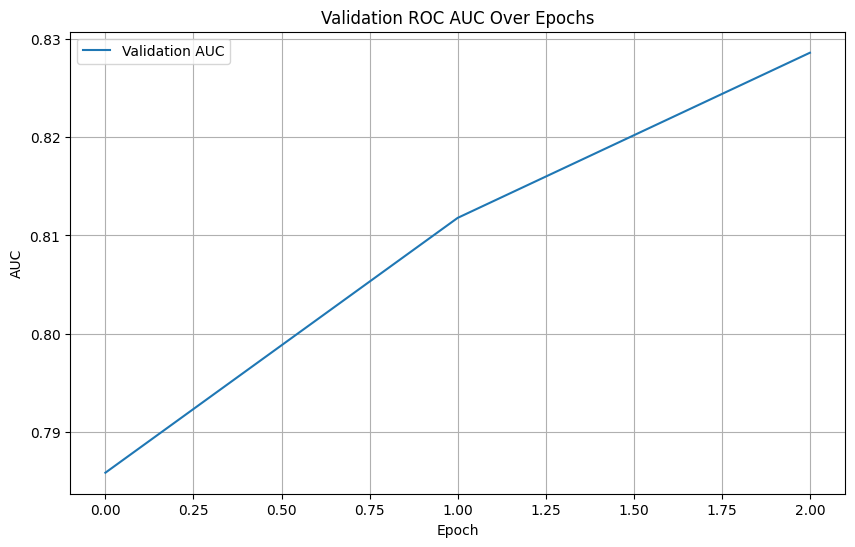

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()